In [ ]:


import pandas as pd
import numpy as np

import datetime

def preprocess_3h(df):

    x = df.copy()

    x['dttm'] = x.apply(
        lambda y: datetime.datetime(
            int(y.year), int(y.month), 
            int(y.day), int(y['hour from']), 0), axis=1)
    
    x_3h = x.sort_values(by='dttm').iloc[:: 3]
    return x_3h

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [ ]:
ROOT_PATH = '/content/drive/MyDrive/kp_data'

import os
import glob

files = glob.glob(os.path.join(ROOT_PATH, '*'))

files = dict(map(lambda x: (x.split('/')[-1], x), files))

In [ ]:
df = pd.read_csv(
    files['All_browse_data_без_погружения_19971021_20211231_с_пропусками.csv'], 
    encoding='cp1251', na_values='N').pipe(preprocess_3h)
print(df.shape)
df.head()

(70776, 64)


,year,month,day,hour from,hour to,doySin,hourSin,doyCos,hourCos,Dst,Lg_Dst,Kp*10,KpH,AE,lg(AE),ULFgr,lg(ULFgr),ULFgeo,lg(ULFgeo),ULFimf,lg(ULFimf),ULFden,lg(ULFden),B_rtn_r,B_rtn_t,B_rtn_n,B_x,B_gse_y,B_gse_z,B_gsm_y,B_gsm_z,B_magn,SW_spd,SW_spd_Clip290,H_den_SWP,lg(H_den_SWP),He_ratio_SWP,lg(He_ratio),Trr_SWP,lg(Trr),p=n*v*v/2,lg(p),Bs,vBs,E=vBmagn,?c=arctan(By/Bz),?2,E_KL,E_KLV,E_WAV,E_TL,dФ_MP/dt,E>0.8 MeV,"lg(E>0,8 MeV)",E>2 MeV,lg(E>2 MeV),E>2 MeV G16,lg(E>2 MeV) G16,CH_rca (193),CH_rca (211),SW_spd_frcst (193),SW_spd_frcst (211),Unnamed: 62,dttm
0,1997,10,21,0,1,-0.505271,0.991445,-0.862961,-0.130526,-14,2.056905,13,13.0,97.0,1.986772,2.97,0.472756,1.03,0.012837,NaN,NaN,NaN,NaN,-0.5200,-2.8146,-0.4584,0.5109,2.7669,-0.6968,2.5359,-1.3079,2.9758,314.1321,314.1321,12.9222,1.111336,0.0048,-2.318759,19301.0,4.285580,637574.7335,5.804531,-1.3079,-410.853374,934.794303,-1.094625,204.009280,253.151859,15965.17718,68.556113,20964.85167,774.055916,NaN,NaN,5.191667,0.715307,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1997-10-21 00:00:00
3,1997,10,21,3,4,-0.507126,0.608761,-0.861872,-0.793353,-13,2.053078,7,11.0,79.0,1.897627,4.26,0.629410,0.29,-0.537602,NaN,NaN,NaN,NaN,-1.7296,-3.4436,-0.0115,1.7186,3.4354,-0.3063,3.0987,-1.5146,3.9844,314.1683,314.1683,8.7635,0.942678,0.0121,-1.917215,17707.0,4.248145,432486.2648,5.635972,-1.5146,-475.839307,1251.772175,-1.116160,392.233359,351.037444,20752.46157,98.442264,25675.02668,985.286740,NaN,NaN,2.082444,0.318573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1997-10-21 03:00:00
6,1997,10,21,6,7,-0.508980,-0.130526,-0.860779,-0.991445,-15,2.060698,10,8.0,172.0,2.235528,3.83,0.583199,0.99,-0.004365,NaN,NaN,NaN,NaN,0.3850,-2.0324,1.0187,-0.3912,2.1110,0.8411,2.2552,-0.2791,3.3428,311.0230,311.0230,14.8348,1.171282,0.0031,-2.508638,27439.0,4.438368,717524.4626,5.855837,-0.2791,-86.806519,1039.687684,-1.447664,668.542982,455.995881,29232.40459,199.994909,105077.64120,1569.908344,NaN,NaN,1.177167,0.070838,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1997-10-21 06:00:00
9,1997,10,21,9,10,-0.510831,-0.793353,-0.859681,-0.608761,-13,2.053078,10,10.0,54.0,1.732394,3.94,0.595496,0.50,-0.301030,0.38,-0.420216,0.95,-0.022276,0.7018,-2.1733,0.5781,-0.7086,2.2126,0.3898,2.0875,-0.8307,2.5349,308.0456,308.0456,15.8484,1.199985,0.0044,-2.356547,27392.0,4.437624,751943.9129,5.876185,-0.8307,-255.893480,780.864791,-1.192067,196.569412,246.073855,15847.76606,77.545233,29967.63429,829.430645,NaN,NaN,3.173833,0.501584,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1997-10-21 09:00:00
12,1997,10,21,12,13,-0.512679,-0.991445,-0.858580,0.130526,-10,2.041393,7,9.0,150.0,2.176091,7.65,0.883661,0.20,-0.698970,0.30,-0.522879,NaN,NaN,3.7120,-2.3427,1.7193,-3.7192,2.4701,1.5132,2.8925,0.1565,4.7589,300.7700,300.7700,13.3870,1.126683,0.0069,-2.161151,27376.0,4.437370,605511.3656,5.782122,0.0000,0.000000,1431.334353,1.516744,1523.862187,677.002238,41721.05925,320.213114,166672.62320,2101.111435,NaN,NaN,10.257500,1.011042,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1997-10-21 12:00:00


In [ ]:
ts = df.set_index('dttm')['Kp*10']

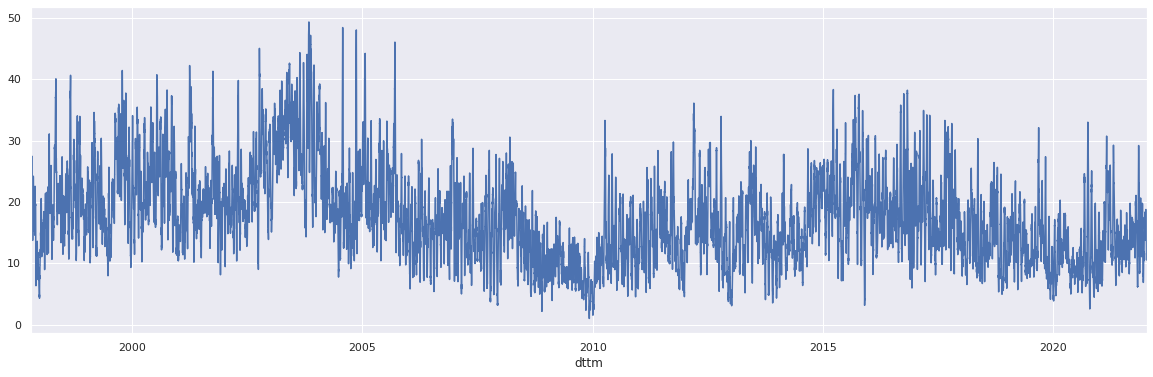

In [ ]:
ts.rolling(56).mean().plot(figsize=(20, 6))

In [ ]:
def generate_train_test(df: pd.DataFrame, date_from: datetime.datetime=None, 
                        n_splits: int=5, future_size: int=None) -> tuple:

    '''Yields train and test samples from date_from, n_splits controls number of pairs'''

    if date_from is not None:
        df_hist, df = (
            df.loc[df.dttm < date_from].reset_index(drop=True), 
            df.loc[df.dttm >= date_from].reset_index(drop=True))

    N = len(df)

    train_size = N // (n_splits + 1)

    for i in range(n_splits):

        right_border = (i + 1) * train_size  + future_size if future_size is not None else None

        X, y = (
            df.iloc[: (i + 1) * train_size], 
            df.iloc[(i + 1) * train_size: right_border])

        if date_from is not None:
            yield pd.concat([df_hist, X], ignore_index=True), y
        else:
            yield X, y

In [ ]:
ts_df = ts.reset_index()

In [ ]:
iterator = generate_train_test(ts_df, date_from='2019-01-01 00:00:00', n_splits=20, future_size=24 // 3)

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
sm = ExponentialSmoothing(ts, seasonal='add', trend='add', seasonal_periods=7 * 4 * 24 // 3)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency 3H will be used.
  % freq, ValueWarning)


In [ ]:
model_fitted = sm.fit(smoothing_slope=.00001, smoothing_seasonal=.5, smoothing_level=.01)

In [ ]:
future = model_fitted.forecast(24 // 3 )

In [ ]:
ts

dttm
1997-10-21 00:00:00    13
1997-10-21 03:00:00     7
1997-10-21 06:00:00    10
1997-10-21 09:00:00    10
1997-10-21 12:00:00     7
                       ..
2022-01-09 09:00:00    10
2022-01-09 12:00:00    17
2022-01-09 15:00:00    13
2022-01-09 18:00:00    20
2022-01-09 21:00:00    27
Name: Kp*10, Length: 70776, dtype: int64

In [ ]:
future

2022-01-10 00:00:00     7.995939
2022-01-10 03:00:00    18.646940
2022-01-10 06:00:00    14.338657
2022-01-10 09:00:00    12.064211
2022-01-10 12:00:00     6.544058
2022-01-10 15:00:00     7.832045
2022-01-10 18:00:00    15.644755
2022-01-10 21:00:00    17.189313
Freq: 3H, dtype: float64

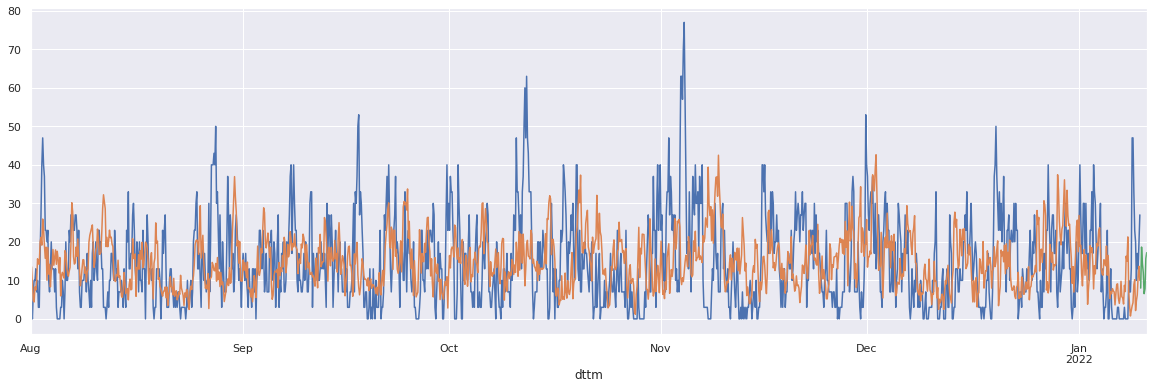

In [ ]:
ts.last('6m').plot(figsize=(20, 6))
model_fitted.fittedvalues.last('6m').plot()

future.plot()

In [ ]:
n_splits = 40

cv = generate_train_test(ts_df, date_from='2019-01-01 00:00:00', n_splits=40, 
                         future_size=24 // 3)

from tqdm.notebook import tqdm

cv_results = []

for i in tqdm(range(n_splits)):
    X, y = next(cv)
    X = X.set_index('dttm')['Kp*10'].asfr             eq('3h')
    y = y.set_index('dttm')['Kp*10'].asfreq('3h')

    sm = ExponentialSmoothing(X, seasonal='add', trend='add', 
                              seasonal_periods=7 * 4 * 24 // 3)
    
    model = sm.fit(smoothing_slope=.00001, smoothing_seasonal=.5, smoothing_level=.01)

    fcast = model.forecast(24 // 3).rename('Kp*10_fcast').asfreq('3h')
    cv_results.append((X, y, fcast))

  0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
cv_results = list(map(
    lambda x: (x[0], x[1].set_index('dttm')['Kp*10'].asfreq('3h'), x[2].asfreq('3h')),
    cv_results

))

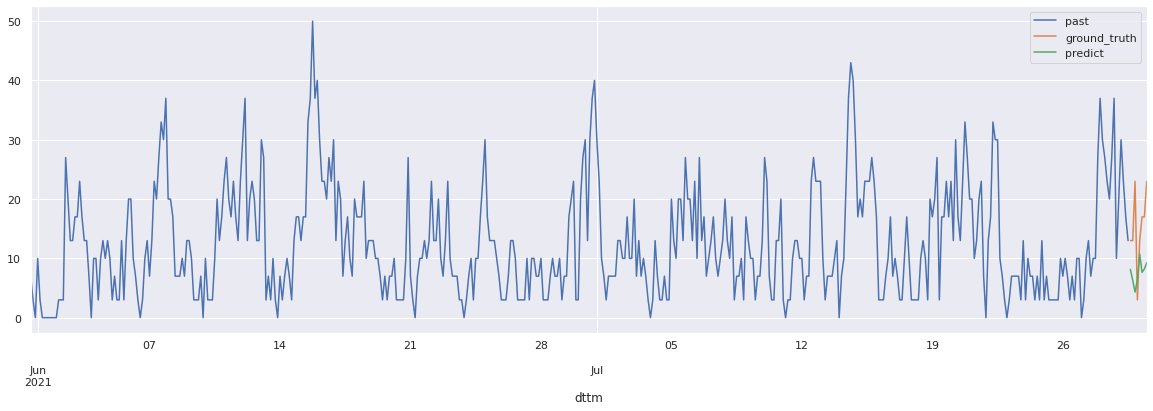

In [ ]:
X0, y0, fcast0 = cv_results[34]

X0.asfreq('3h').last('2m').plot(figsize=(20, 6), label='past')

y0.set_index('dttm')['Kp*10'].asfreq('3h').plot(figsize=(20, 6), label='ground_truth')

fcast0.asfreq('3h').last('6m').plot(figsize=(20, 6), label='predict')

plt.legend()

In [ ]:

cv_results_df = []
for i, (X, y, fcast) in enumerate(cv_results):

    y_total = y.to_frame().join(fcast).reset_index().assign(split=i).sort_values(by='dttm').assign(step=lambda x: np.arange(len(x)))
    cv_results_df.append(y_total)

cv_results_df = pd.concat(cv_results_df, ignore_index=True)

cv_results_df['error'] = cv_results_df['Kp*10_fcast'] - cv_results_df['Kp*10']
cv_results_df['error'] = cv_results_df['Kp*10_fcast'] - cv_results_df['Kp*10']
cv_results_df['squared_error'] = cv_results_df.error ** 2
cv_results_df['abs_error'] = cv_results_df.error.apply(np.abs)

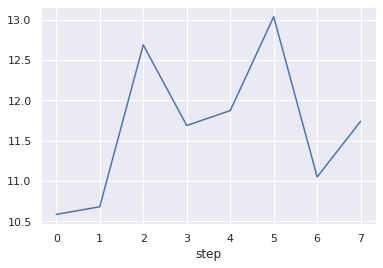

In [ ]:
cv_results_df.groupby('step').squared_error.mean().apply(np.sqrt).plot()

In [ ]:
res0 = cv_results_df.groupby('step').abs_error.quantile(.75)
res0_mse = cv_results_df.groupby('step').squared_error.mean().apply(np.sqrt)

In [ ]:
res0

step
0    11.096190
1    10.216842
2    13.707263
3    12.433571
4    10.318604
5    11.772345
6     9.192190
7    13.900280
Name: abs_error, dtype: float64

In [ ]:
res0_mse

step
0    10.583958
1    10.679129
2    12.687316
3    11.687243
4    11.871158
5    13.036358
6    11.048871
7    11.739890
Name: squared_error, dtype: float64

In [ ]:
n_splits = 40

cv = generate_train_test(ts_df, date_from='2019-01-01 00:00:00', n_splits=40, 
                         future_size=24 // 3)

from tqdm.notebook import tqdm

cv_results = []

for i in tqdm(range(n_splits)):
    X, y = next(cv)
    X = X.set_index('dttm')['Kp*10'].asfreq('3h')
    y = y.set_index('dttm')['Kp*10'].asfreq('3h')

    sm = ExponentialSmoothing(X, seasonal='add', trend='add', 
                              seasonal_periods=7 * 4 * 24 // 3)
    
    model = sm.fit(optimized=True)

    fcast = model.forecast(24 // 3).rename('Kp*10_fcast').asfreq('3h')
    cv_results.append((X, y, fcast))

  0%|          | 0/40 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  Conver

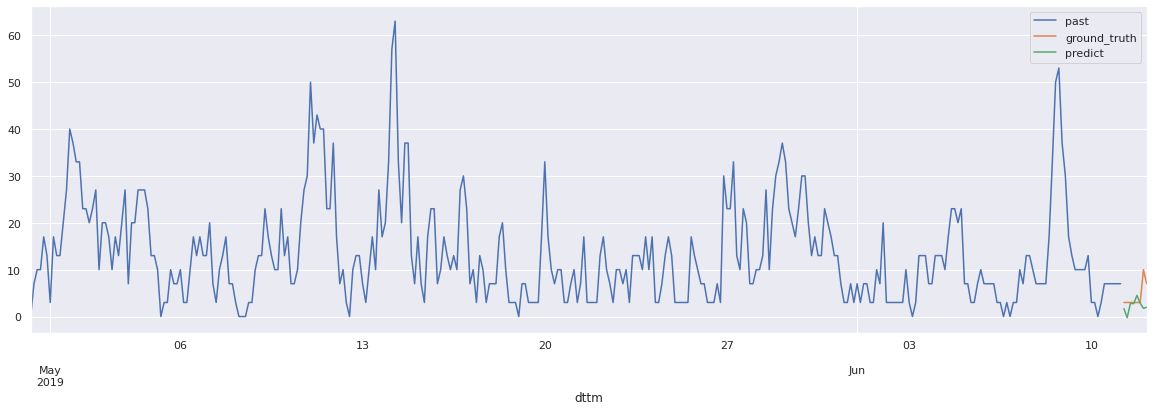

In [ ]:
X0, y0, fcast0 = cv_results[5]

X0.last('2m').plot(figsize=(20, 6), label='past')

y0.plot(figsize=(20, 6), label='ground_truth')

fcast0.last('6m').plot(figsize=(20, 6), label='predict')

plt.legend()

In [ ]:

cv_results_df = []
for i, (X, y, fcast) in enumerate(cv_results):

    y_total = y.to_frame().join(fcast).reset_index().assign(split=i).sort_values(by='dttm').assign(step=lambda x: np.arange(len(x)))
    cv_results_df.append(y_total)

cv_results_df = pd.concat(cv_results_df, ignore_index=True)

cv_results_df['error'] = cv_results_df['Kp*10_fcast'] - cv_results_df['Kp*10']
cv_results_df['error'] = cv_results_df['Kp*10_fcast'] - cv_results_df['Kp*10']
cv_results_df['squared_error'] = cv_results_df.error ** 2
cv_results_df['abs_error'] = cv_results_df.error.apply(np.abs)

res1 = cv_results_df.groupby('step').abs_error.quantile(.75)
res1_mse = cv_results_df.groupby('step').squared_error.mean().apply(np.sqrt)

In [ ]:
res1

step
0     6.677413
1     8.716262
2    11.383033
3    13.576524
4    14.016381
5    12.032683
6    13.520663
7     9.725796
Name: abs_error, dtype: float64

In [ ]:
res0

step
0    11.096190
1    10.216842
2    13.707263
3    12.433571
4    10.318604
5    11.772345
6     9.192190
7    13.900280
Name: abs_error, dtype: float64

In [ ]:
def _choose_suffix_name(forward: bool, suffix_name: str) -> str:
    if suffix_name is not None:
        return suffix_name
    else:
        return 'lead' if forward else 'lag'

def _trim(df: pd.DataFrame, forward: bool, trim: bool, lags: int) -> pd.DataFrame:
    if trim and forward:
        return df.iloc[: -lags]
    elif trim:
        return df.iloc[lags: ]
    else:
        return df

def add_lags(df: pd.DataFrame, subset: list=None, forward: bool=False,
             lags: int=1, trim: bool=False, suffix_name: str=None,
             return_cols=False) -> pd.DataFrame:

    suffix_name = _choose_suffix_name(forward, suffix_name)

    x = df.copy()

    digits = len(str(lags))

    columns = []

    if not isinstance(lags, int):
        raise ValueError(f'Lags should be int, {type(lags)} type prodided')
    elif lags < 0:
        raise ValueError(f'Lags should be non-negative')
    elif lags == 0:
        return x
    elif subset is None:
        for i in range(1, lags + 1):
            lag = - i if forward else i
            index = str(i).zfill(digits)
            column_name = f'_{suffix_name}_{index}'
            columns.append(column_name)

            x = x.join(x.shift(lag).add_suffix(column_name))

    elif isinstance(subset, list):
        for i in range(1, lags + 1):
            lag = - i if forward else i
            index = str(i).zfill(digits)
            column_name = f'_{suffix_name}_{index}'
            columns.append(column_name)

            x = x.join(x.loc[:, subset].shift(lag).add_suffix(column_name))

    elif isinstance(subset, str):
        for i in range(1, lags + 1):
            lag = - i if forward else i
            index = str(i).zfill(digits)
            column_name = f'{subset}_{suffix_name}_{index}'
            columns.append(column_name)

            x = x.join(x.loc[:, subset].shift(lag).rename(f'{subset}_{suffix_name}_{index}'))
    else:
        raise ValueError(f'Subset should be str or list, providided type {type(subset)}')

    if return_cols:
        return _trim(x, forward, trim, lags), columns
    else:
        return _trim(x, forward, trim, lags)




In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

from sklearn.multioutput import MultiOutputRegressor

In [ ]:
ts_df_forward, lead_cols = add_lags(ts_df, lags=24 // 3 - 1, forward=True, trim=True, subset='Kp*10', return_cols=True)

ts_df_auto, lag_cols = add_lags(ts_df_forward, lags=30, forward=False, trim=True, subset='Kp*10', return_cols=True)

In [ ]:
lead_cols.append('Kp*10')

In [ ]:
model = MultiOutputRegressor(XGBRegressor(random_state=17))

In [63]:
n_splits = 40

cv = generate_train_test(ts_df_auto, date_from='2019-01-01 00:00:00', n_splits=40, 
                         future_size=1)

from tqdm.notebook import tqdm

cv_results = []

for i in tqdm(range(n_splits)):
    df_past, df_future = next(cv)
    X_train, y_train = df_past[lag_cols], df_past[lead_cols]
    X_test, y_test = df_future[lag_cols], df_future[lead_cols]

    fcast = model.fit(X_train, y_train, ).predict(X_test)

    cv_results.append((y_test, fcast))

  0%|          | 0/40 [00:00<?, ?it/s]

[00:50:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:50:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:51:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:51:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:51:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:51:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:51:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:51:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

KeyboardInterrupt: ignored

In [ ]:
X_train

,Kp*10_lag_01,Kp*10_lag_02,Kp*10_lag_03,Kp*10_lag_04,Kp*10_lag_05,Kp*10_lag_06,Kp*10_lag_07,Kp*10_lag_08,Kp*10_lag_09,Kp*10_lag_10,Kp*10_lag_11,Kp*10_lag_12,Kp*10_lag_13,Kp*10_lag_14,Kp*10_lag_15,Kp*10_lag_16,Kp*10_lag_17,Kp*10_lag_18,Kp*10_lag_19,Kp*10_lag_20,Kp*10_lag_21,Kp*10_lag_22,Kp*10_lag_23,Kp*10_lag_24,Kp*10_lag_25,Kp*10_lag_26,Kp*10_lag_27,Kp*10_lag_28,Kp*10_lag_29,Kp*10_lag_30
0,30.0,53.0,43.0,23.0,27.0,23.0,37.0,23.0,23.0,17.0,20.0,17.0,0.0,0.0,13.0,17.0,7.0,3.0,7.0,3.0,20.0,17.0,7.0,0.0,3.0,7.0,10.0,10.0,7.0,13.0
1,20.0,30.0,53.0,43.0,23.0,27.0,23.0,37.0,23.0,23.0,17.0,20.0,17.0,0.0,0.0,13.0,17.0,7.0,3.0,7.0,3.0,20.0,17.0,7.0,0.0,3.0,7.0,10.0,10.0,7.0
2,33.0,20.0,30.0,53.0,43.0,23.0,27.0,23.0,37.0,23.0,23.0,17.0,20.0,17.0,0.0,0.0,13.0,17.0,7.0,3.0,7.0,3.0,20.0,17.0,7.0,0.0,3.0,7.0,10.0,10.0
3,50.0,33.0,20.0,30.0,53.0,43.0,23.0,27.0,23.0,37.0,23.0,23.0,17.0,20.0,17.0,0.0,0.0,13.0,17.0,7.0,3.0,7.0,3.0,20.0,17.0,7.0,0.0,3.0,7.0,10.0
4,47.0,50.0,33.0,20.0,30.0,53.0,43.0,23.0,27.0,23.0,37.0,23.0,23.0,17.0,20.0,17.0,0.0,0.0,13.0,17.0,7.0,3.0,7.0,3.0,20.0,17.0,7.0,0.0,3.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62116,13.0,20.0,7.0,7.0,27.0,30.0,10.0,13.0,17.0,17.0,17.0,23.0,30.0,33.0,27.0,33.0,27.0,20.0,43.0,37.0,27.0,13.0,13.0,37.0,33.0,37.0,40.0,23.0,23.0,30.0
62117,13.0,13.0,20.0,7.0,7.0,27.0,30.0,10.0,13.0,17.0,17.0,17.0,23.0,30.0,33.0,27.0,33.0,27.0,20.0,43.0,37.0,27.0,13.0,13.0,37.0,33.0,37.0,40.0,23.0,23.0
62118,10.0,13.0,13.0,20.0,7.0,7.0,27.0,30.0,10.0,13.0,17.0,17.0,17.0,23.0,30.0,33.0,27.0,33.0,27.0,20.0,43.0,37.0,27.0,13.0,13.0,37.0,33.0,37.0,40.0,23.0
62119,3.0,10.0,13.0,13.0,20.0,7.0,7.0,27.0,30.0,10.0,13.0,17.0,17.0,17.0,23.0,30.0,33.0,27.0,33.0,27.0,20.0,43.0,37.0,27.0,13.0,13.0,37.0,33.0,37.0,40.0


In [ ]:
df_past['Kp*10_lead_1']

KeyError: ignored